# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
# sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads data

In [3]:
# Specify the filename and the path to save the file
filename = 'data_raw_unmod.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ R

## Performs SHO fits

In [4]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit()

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed res

/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


## Visualize LSQF fit results

In [5]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

# instantiate the dataset object
dataset = BE_Dataset(data_path)

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
(60, 60, 4, 96)
(1, 9)
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


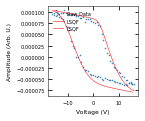

In [22]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [23]:
dataset.loop_param_scaler

StandardScaler()

In [24]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [25]:
dataset.hysteresis_scaler

In [26]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
#                             V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU A100-SXM4-40GB
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/600, recon loss = 0.15932465
--- 1.405885934829712 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/600, recon loss = 0.10540325
--- 0.1142280101776123 seconds ---
Epoch 2, Learning Rate: 0.001
Adam
epoch : 3/600, recon loss = 0.07236160
--- 0.11312603950500488 seconds ---
Epoch 3, Learning Rate: 0.001
Adam
epoch : 4/600, recon loss = 0.05490667
--- 0.11406803131103516 seconds ---
Epoch 4, Learning Rate: 0.001
Adam
epoch : 5/600, recon loss = 0.04736421
--- 0.11210274696350098 seconds ---
Epoch 5, Learning Rate: 0.001
Adam
epoch : 6/600, recon loss = 0.04256225
--- 0.11212992668151855 seconds ---
Epoch 6, Learning Rate: 0.001
Adam
epoch : 7/600, recon loss = 0.03869602
--- 0.11152052879333496 seconds ---
Epoch 7, Learning Rate: 0.001
Adam
epoch : 8/600, recon loss = 0.03554474
--- 0.11111688613891602 seconds ---
Epoch 8, Learning Rate: 0.001
Adam
epoch : 9/600, recon loss = 0.06933050
--- 0.11062335968017578 seconds ---
Epoch 9, Learning Rate: 0.001
Adam
epoch : 

Adam
epoch : 75/600, recon loss = 0.01190950
--- 0.10985684394836426 seconds ---
Epoch 75, Learning Rate: 0.001
Adam
epoch : 76/600, recon loss = 0.01186767
--- 0.11009335517883301 seconds ---
Epoch 76, Learning Rate: 0.001
Adam
epoch : 77/600, recon loss = 0.01184208
--- 0.1103670597076416 seconds ---
Epoch 77, Learning Rate: 0.001
Adam
epoch : 78/600, recon loss = 0.01182740
--- 0.11000823974609375 seconds ---
Epoch 78, Learning Rate: 0.001
Adam
epoch : 79/600, recon loss = 0.01188235
--- 0.11070775985717773 seconds ---
Epoch 79, Learning Rate: 0.001
Adam
epoch : 80/600, recon loss = 0.01200589
--- 0.11057829856872559 seconds ---
Epoch 80, Learning Rate: 0.001
Adam
epoch : 81/600, recon loss = 0.01170689
--- 0.10998916625976562 seconds ---
Epoch 81, Learning Rate: 0.001
Adam
epoch : 82/600, recon loss = 0.01164363
--- 0.11249160766601562 seconds ---
Epoch 82, Learning Rate: 0.001
Adam
epoch : 83/600, recon loss = 0.01151652
--- 0.11088109016418457 seconds ---
Epoch 83, Learning Rate:

Adam
epoch : 149/600, recon loss = 0.00920847
--- 0.10976076126098633 seconds ---
Epoch 149, Learning Rate: 0.001
Adam
epoch : 150/600, recon loss = 0.00917618
--- 0.10940003395080566 seconds ---
Epoch 150, Learning Rate: 0.001
Adam
epoch : 151/600, recon loss = 0.00917560
--- 0.11020731925964355 seconds ---
Epoch 151, Learning Rate: 0.001
Adam
epoch : 152/600, recon loss = 0.00926434
--- 0.10988545417785645 seconds ---
Epoch 152, Learning Rate: 0.001
Adam
epoch : 153/600, recon loss = 0.00925382
--- 0.11030864715576172 seconds ---
Epoch 153, Learning Rate: 0.001
Adam
epoch : 154/600, recon loss = 0.00919905
--- 0.10949325561523438 seconds ---
Epoch 154, Learning Rate: 0.001
Adam
epoch : 155/600, recon loss = 0.00915850
--- 0.10993099212646484 seconds ---
Epoch 155, Learning Rate: 0.001
Adam
epoch : 156/600, recon loss = 0.00911408
--- 0.10909056663513184 seconds ---
Epoch 156, Learning Rate: 0.001
Adam
epoch : 157/600, recon loss = 0.00911010
--- 0.10927462577819824 seconds ---
Epoch 

Adam
epoch : 221/600, recon loss = 0.00867495
--- 0.10991334915161133 seconds ---
Epoch 221, Learning Rate: 0.001
Adam
epoch : 222/600, recon loss = 0.00865223
--- 0.11007261276245117 seconds ---
Epoch 222, Learning Rate: 0.001
Adam
epoch : 223/600, recon loss = 0.00871153
--- 0.10964274406433105 seconds ---
Epoch 223, Learning Rate: 0.001
Adam
epoch : 224/600, recon loss = 0.00864780
--- 0.10964465141296387 seconds ---
Epoch 224, Learning Rate: 0.001
Adam
epoch : 225/600, recon loss = 0.00869086
--- 0.11021971702575684 seconds ---
Epoch 225, Learning Rate: 0.001
Adam
epoch : 226/600, recon loss = 0.00866908
--- 0.1093590259552002 seconds ---
Epoch 226, Learning Rate: 0.001
Adam
epoch : 227/600, recon loss = 0.00864591
--- 0.10990238189697266 seconds ---
Epoch 227, Learning Rate: 0.001
Adam
epoch : 228/600, recon loss = 0.00865919
--- 0.11002326011657715 seconds ---
Epoch 228, Learning Rate: 0.001
Adam
epoch : 229/600, recon loss = 0.00881725
--- 0.10989189147949219 seconds ---
Epoch 2

Adam
epoch : 294/600, recon loss = 0.00833182
--- 0.10987377166748047 seconds ---
Epoch 294, Learning Rate: 0.001
Adam
epoch : 295/600, recon loss = 0.00818486
--- 0.10915684700012207 seconds ---
Epoch 295, Learning Rate: 0.001
Adam
epoch : 296/600, recon loss = 0.00829978
--- 0.10976958274841309 seconds ---
Epoch 296, Learning Rate: 0.001
Adam
epoch : 297/600, recon loss = 0.00820972
--- 0.10975289344787598 seconds ---
Epoch 297, Learning Rate: 0.001
Adam
epoch : 298/600, recon loss = 0.00820812
--- 0.10935783386230469 seconds ---
Epoch 298, Learning Rate: 0.001
Adam
epoch : 299/600, recon loss = 0.00815021
--- 0.10945010185241699 seconds ---
Epoch 299, Learning Rate: 0.001
Adam
epoch : 300/600, recon loss = 0.00814737
--- 0.1105341911315918 seconds ---
Epoch 300, Learning Rate: 0.001
Adam
epoch : 301/600, recon loss = 0.00818392
--- 0.11021065711975098 seconds ---
Epoch 301, Learning Rate: 0.001
Adam
epoch : 302/600, recon loss = 0.00836244
--- 0.10998272895812988 seconds ---
Epoch 3

Adam
epoch : 366/600, recon loss = 0.00764767
--- 0.10923314094543457 seconds ---
Epoch 366, Learning Rate: 0.001
Adam
epoch : 367/600, recon loss = 0.00762768
--- 0.10906338691711426 seconds ---
Epoch 367, Learning Rate: 0.001
Adam
epoch : 368/600, recon loss = 0.00758121
--- 0.10942220687866211 seconds ---
Epoch 368, Learning Rate: 0.001
Adam
epoch : 369/600, recon loss = 0.00756980
--- 0.10924768447875977 seconds ---
Epoch 369, Learning Rate: 0.001
Adam
epoch : 370/600, recon loss = 0.00757151
--- 0.10910415649414062 seconds ---
Epoch 370, Learning Rate: 0.001
Adam
epoch : 371/600, recon loss = 0.00770287
--- 0.10933327674865723 seconds ---
Epoch 371, Learning Rate: 0.001
Adam
epoch : 372/600, recon loss = 0.00778674
--- 0.10923290252685547 seconds ---
Epoch 372, Learning Rate: 0.001
Adam
epoch : 373/600, recon loss = 0.00788388
--- 0.10916686058044434 seconds ---
Epoch 373, Learning Rate: 0.001
Adam
epoch : 374/600, recon loss = 0.00760721
--- 0.1097569465637207 seconds ---
Epoch 3

Adam
epoch : 438/600, recon loss = 0.00722840
--- 0.1091616153717041 seconds ---
Epoch 438, Learning Rate: 0.001
Adam
epoch : 439/600, recon loss = 0.00719133
--- 0.10869741439819336 seconds ---
Epoch 439, Learning Rate: 0.001
Adam
epoch : 440/600, recon loss = 0.00724178
--- 0.1096944808959961 seconds ---
Epoch 440, Learning Rate: 0.001
Adam
epoch : 441/600, recon loss = 0.00720296
--- 0.10937714576721191 seconds ---
Epoch 441, Learning Rate: 0.001
Adam
epoch : 442/600, recon loss = 0.00713808
--- 0.10932087898254395 seconds ---
Epoch 442, Learning Rate: 0.001
Adam
epoch : 443/600, recon loss = 0.00717083
--- 0.10915422439575195 seconds ---
Epoch 443, Learning Rate: 0.001
Adam
epoch : 444/600, recon loss = 0.00714460
--- 0.10940194129943848 seconds ---
Epoch 444, Learning Rate: 0.001
Adam
epoch : 445/600, recon loss = 0.00720128
--- 0.10936784744262695 seconds ---
Epoch 445, Learning Rate: 0.001
Adam
epoch : 446/600, recon loss = 0.00720219
--- 0.11001467704772949 seconds ---
Epoch 44

Trust Region CG
epoch : 510/600, recon loss = 0.00642027
--- 5.233259201049805 seconds ---
Epoch 510, Learning Rate: 0.001
Trust Region CG
epoch : 511/600, recon loss = 0.00638385
--- 4.6487579345703125 seconds ---
Epoch 511, Learning Rate: 0.001
Trust Region CG
epoch : 512/600, recon loss = 0.00636323
--- 4.158113718032837 seconds ---
Epoch 512, Learning Rate: 0.001
Trust Region CG
epoch : 513/600, recon loss = 0.00638197
--- 4.770308017730713 seconds ---
Epoch 513, Learning Rate: 0.001
Trust Region CG
epoch : 514/600, recon loss = 0.00632375
--- 3.218642473220825 seconds ---
Epoch 514, Learning Rate: 0.001
Trust Region CG
epoch : 515/600, recon loss = 0.00631456
--- 3.146005392074585 seconds ---
Epoch 515, Learning Rate: 0.001
Trust Region CG
epoch : 516/600, recon loss = 0.00630867
--- 2.591956853866577 seconds ---
Epoch 516, Learning Rate: 0.001
Trust Region CG
epoch : 517/600, recon loss = 0.00630087
--- 2.476593494415283 seconds ---
Epoch 517, Learning Rate: 0.001
Trust Region CG

Trust Region CG
epoch : 577/600, recon loss = 0.00611693
--- 6.00339412689209 seconds ---
Epoch 577, Learning Rate: 0.001
Trust Region CG
epoch : 578/600, recon loss = 0.00610883
--- 5.181626796722412 seconds ---
Epoch 578, Learning Rate: 0.001
Trust Region CG
epoch : 579/600, recon loss = 0.00608773
--- 3.3295061588287354 seconds ---
Epoch 579, Learning Rate: 0.001
Trust Region CG
epoch : 580/600, recon loss = 0.00608049
--- 3.962480306625366 seconds ---
Epoch 580, Learning Rate: 0.001
Trust Region CG
epoch : 581/600, recon loss = 0.00607719
--- 3.0813653469085693 seconds ---
Epoch 581, Learning Rate: 0.001
Trust Region CG
epoch : 582/600, recon loss = 0.00607957
--- 3.337550401687622 seconds ---
Epoch 582, Learning Rate: 0.001
Trust Region CG
epoch : 583/600, recon loss = 0.00607434
--- 3.0394537448883057 seconds ---
Epoch 583, Learning Rate: 0.001
Trust Region CG
epoch : 584/600, recon loss = 0.00607249
--- 2.885345458984375 seconds ---
Epoch 584, Learning Rate: 0.001
Trust Region C

In [29]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False
)

/home/alk224/JOB_TMPDIR/ipykernel_689602/3006655976.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.atleast_3d(torch.tensor(X_train))


In [30]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

torch.Size([11520, 9])

In [31]:
X_train[1000].shape

torch.Size([96, 1])

In [32]:
voltage.shape

(96, 1)

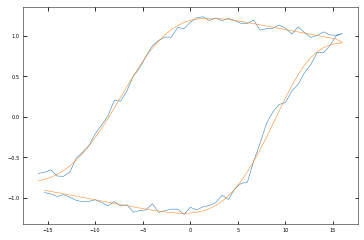

In [33]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

### Evaluate the Neural Network Results

/home/alk224/workspace/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:999: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


(11520, 96, 1)
(11520, 96, 1)
./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


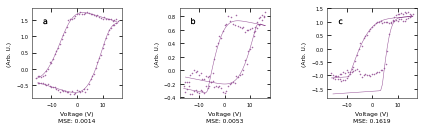

In [34]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

(2880, 96, 1)
(2880, 96, 1)
./Figures/Figure_X_NN_validation_Test.png
./Figures/Figure_X_NN_validation_Test.svg


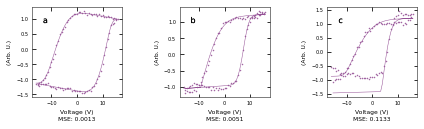

In [35]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [36]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels)

Full Data Mean Squared Error: 0.0061
Test Data Mean Squared Error: 0.0059
Train Data Mean Squared Error: 0.0061


## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/alk224/workspace/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:999: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


(14400, 96, 1)
(14400, 96, 1)
torch.Size([9])
torch.Size([9])
torch.Size([9])
./Figures/Figure_14_LSQF_NN_bmw_comparison.png
./Figures/Figure_14_LSQF_NN_bmw_comparison.svg


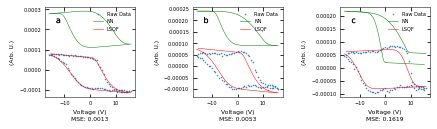

In [49]:
n = 1
# data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

# LSQF, NN, v1, v2, index1, mse1 = BE_viz.get_best_median_worst_hysteresis(
#     torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
#     prediction=model,
#     n=n
# )

# NN = BE_viz.get_best_median_worst_hysteresis(
#     torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
#     prediction=model,
#     n=n
# )

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.hysteresis_comparison(
    data,
    model=model,
    filename="Figure_14_LSQF_NN_bmw_comparison",
)

## Plot a Random Example of the fit

In [24]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

self = BE_viz

In [25]:
dataset.get_state

{'resampled': False,
 'raw_format': 'complex',
 'fitter': 'LSQF',
 'scaled': False,
 'output_shape': 'pixels',
 'measurement_state': 'all',
 'resampled_bins': 165,
 'LSQF_phase_shift': None,
 'NN_phase_shift': None,
 'noise': 0,
 'loop_interpolated': False}

In [30]:
out, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


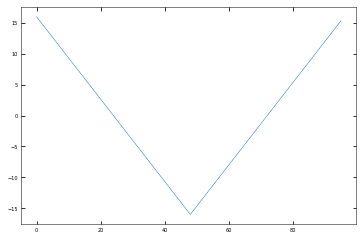

In [31]:
# plt.plot(dataset.dc_voltage)
plt.plot(V)

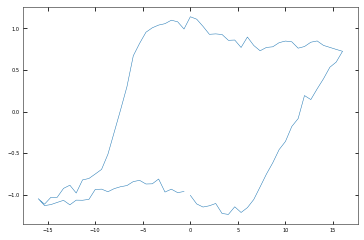

In [32]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(voltage[:,0].squeeze(), out[a,b,0].squeeze())

In [33]:
hys, bias = dataset.get_hysteresis()

hys_2 = clean_interpolate(hys, axis=3)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [34]:
def find_non_finite_indices(arr):
    non_finite_mask = ~np.isfinite(arr)
    indices = np.argwhere(non_finite_mask)
    return indices

In [35]:
hys.shape

(60, 60, 4, 96)

In [36]:
find_non_finite_indices(hys)

array([], shape=(0, 4), dtype=int64)

In [37]:
a

array([7])

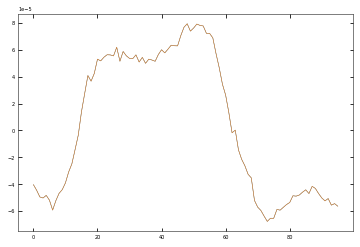

In [38]:
import matplotlib.pyplot as plt

a = np.random.randint(0,60,(1))
b = np.random.randint(0,60,(1))


plt.plot(hys[a[0],b[0],0])
plt.plot(hys_2[a[0],b[0],0])

In [39]:
def hysteresis_fit(self, 
                   voltage, 
                   datasets, 
                   original = True,
                   row = None, 
                   col = None,
                   cycle = None):
    
    if row is None:
        row = np.random.randint(0, self.dataset.num_rows, 1)
        
    if col is None:
        col = np.random.randint(0, self.dataset.num_cols, 1)
        
    if cycle is None:
        cycle = np.random.randint(0, self.dataset.num_cycles, 1)
    
    fig, ax = subfigures(1,1, size = (1.25,1.25))
    

        

AttributeError: 'list' object has no attribute 'plot'

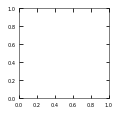

In [40]:
from m3_learning.viz.layout import layout_fig, inset_connector, add_box, subfigures, add_text_to_figure, get_axis_pos_inches, imagemap,  FigDimConverter, labelfigs, imagemap, scalebar

fig, axs = subfigures(1,1, size = (1.25,1.25))


axs.plot(V, proj_nd_shifted_transposed[i[0], i[1], :, 3],'og',
         label='initial loops')
axs.plot(V, loop_fit_results[:, i[0], i[1]], 'blue', label='fit results (NumPy)')
axs.plot(V, np.reshape(loop_fitting_function_tf(func_type, V, params), 
                       (num_pix_1d, num_pix_1d, 96))[i[0], i[1], :], 'black', 
         label='fit results (Tensorflow)')
axs.legend()
axs.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
axs.label_outer()

(60, 60, 4, 9)

In [ ]:
with h5py.File(dataset.file, "r+") as h5_f:
    
    out = h5_f['/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit'][:]

In [ ]:
dataset.num_cols

In [ ]:
parm = dataset.LSQF_hysteresis_params(output_shape = "index")

In [ ]:
parm.shape


In [ ]:
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)
out.shape

In [76]:
import matplotlib.pyplot as plt

self = dataset

col = np.random.randint(0, self.num_cols, 1)
cycle = pos = np.random.randint(0, 4, 1)
row = 20

parm = dataset.LSQF_hysteresis_params()[row, col, cycle].view('<f4')
loop = loop_fitting_function_torch(bias[:, cycle], parm, type='9 parameters')
out, bias = dataset.get_hysteresis("/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000", plotting_values=True)



plt.plot(bias[:, cycle].squeeze(), loop.cpu().squeeze(), 'r')
plt.plot(bias[:, cycle].squeeze(), out[row, col, :, cycle].squeeze(), 'b')

type: name 'loop_fitting_function_torch' is not defined

In [ ]:
from scipy.special import erf, erfinv
import warnings

def loop_fit_function(vdc, coef_vec):
    """
    9 parameter fit function
    
    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector
        
    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """

    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

In [ ]:
plt.plot(bias[:,0])

In [ ]:
loop_eval = loop_fit_function(bias[:,0], parm)

In [ ]:
plt.plot(bias[:,cycle].squeeze(), loop_eval)

In [ ]:
dataset.LSQF_hysteresis_params()[0,0]

In [ ]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch

In [ ]:
with h5py.File("/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_SHO.h5", "r+") as h5_f:
    # number of pixels in the image
    num_pix = h5_f["Measurement_000"].attrs["num_pix"]
    
    # voltage vector
    V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)
    
    params = np.array(h5_f['Fit_Loop_Parameters'][:])
    

In [ ]:
dataset.dataset

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dataset.hysteresis_waveform)


In [ ]:
# # Sets path to file
# path = r"./"

# # Opens the data file2
# h5_f = h5py.File(path + "data_file.h5", "r+")


# # number of pixels in the image
# num_pix = h5_f["Measurement_000"].attrs["num_pix"]
# #dataset.num_pix

# num_pix_1d = int(np.sqrt(num_pix))
# #dataset.num_pix


# # number of DC voltage steps
# voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# proj_nd_shifted = loop_lsqf(h5_f)
# proj_nd_shifted_transposed = np.transpose(proj_nd_shifted,(1,0,2,3))

# getting parameters for the hysteresis loops
params = np.array(h5_f['params_hysteresis'][:])
params_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3']

# voltage vector
V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)

# to set up a type of loop_fitting function to use. Possible options: ['9 parameters', '13 parameters']
func_type = '9 parameters'

# retrieve results
real_loops = np.array(h5_f['real_loops_hysteresis'][:])
unscaled_param_trust = np.array(h5_f['predictions_hysteresis_trustregcg'][:])
unscaled_param_adam = np.array(h5_f['predictions_hysteresis_adam'][:])